In [1]:
# Utils
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode

# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot.plotters as skplt



/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so | _pywrap_tensorflow_internal


# Load Data

In [3]:
root_path = "../"
path_data_raw = root_path + "data/raw/"
dfNoticias = pd.read_pickle(path_data_raw+"dfNoticias")

# Data info

In [7]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
1,\nMarcel Granollers (44°) sorprendió a David F...,20140929,09:57,20140929095927,\nEl español cayó ante su compatriota Marcel G...,Deportes,None,None,Torneos ATP,None,None,Tenis,None,None,\nDavid Ferrer sufrió otra temprana eliminación\n,fid_noticia
2,\nEl Gobierno de Barack Obama ha enviado cuatr...,20140929,07:03,20140929065051,\nLas conversaciones comenzaron el año 2010 y ...,País,Mundo,Mundo,EE.UU.,Relaciones Exteriores,None,Relaciones Exteriores,EE.UU.,Cuba,\nObama ha enviado cuatro solicitudes a Chile ...,fid_noticia
3,\nEste miércoles la Comisión Asesora Presidenc...,20140929,11:37,20140929105234,\nRepresentantes del sector privado acusaron q...,País,None,None,Isapre,None,None,Salud,None,None,\nQuiebre en comisión presidencial de isapres ...,fid_noticia
4,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929100825,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
5,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929130450,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia


In [19]:
dfNoticias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250759 entries, 1 to 389889
Data columns (total 16 columns):
Cuerpo       250639 non-null object
Fecha        250759 non-null object
Hora         250759 non-null object
ID           250759 non-null object
Resumen      249632 non-null object
Seccion_1    250459 non-null object
Seccion_2    123240 non-null object
Seccion_3    37532 non-null object
Subtema_1    182753 non-null object
Subtema_2    74385 non-null object
Subtema_3    24247 non-null object
Tema_1       248508 non-null object
Tema_2       116973 non-null object
Tema_3       36153 non-null object
Titular      250759 non-null object
Type         250759 non-null object
dtypes: object(16)
memory usage: 32.5+ MB


### elementos nulos

Existen noticias con el cuerpo en nulo, primeras en ser borradas.
Tambien con seccion_1 en nulo, borrar tambien.

In [21]:
pd.isnull(dfNoticias).any()

Cuerpo        True
Fecha        False
Hora         False
ID           False
Resumen       True
Seccion_1     True
Seccion_2     True
Seccion_3     True
Subtema_1     True
Subtema_2     True
Subtema_3     True
Tema_1        True
Tema_2        True
Tema_3        True
Titular      False
Type         False
dtype: bool

### Cantidades totales por cada columnas, cantidad de elementos no repetidos, elemento mas repetido y la cantidad de veces que se repite este

Aca se pueden ver las cantidades de noticias etiquetadas y la cantidad de etiquetas, para seccionx, temax y subtemaX

620 noticias con cuerpo repetido, "/n/n", borrar tambien.

In [16]:
dfNoticias.describe(include="all")

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
count,250639,250759,250759,250759,249632,250459,123240,37532,182753,74385,24247,248508,116973,36153,250759,250759
unique,238968,2171,1416,250759,236300,9,10,9,1481,1270,902,237,237,219,239031,1
top,\n\n,20110831,00:01,20150425082036,\n\n,Deportes,Deportes,Deportes,Colo Colo,Selección chilena,Chilenos en el exterior,Fútbol,Fútbol,Fútbol,\nEstrenos de cine\n,fid_noticia
freq,620,183,924,1,1206,80576,58249,20668,3312,2114,1076,43438,35295,14165,36,250759


### Ejemplo texto de una noticia
Falta limpar caracteres como /n

In [53]:
dfNoticias["Cuerpo"].iloc[100]

'\nLa serie de televisión "Miami Vice" cumple 30 años, y desde su creación ha sido considerada la plataforma que dio a conocer ante el mundo a esta glamourosa ciudad del sureste de Estados Unidos y que también la ayudó a resurgir.\nCon una trama que combinó la moda y los lujosos convertibles, yates y hoteles con problemas de tráfico de cocaína y prostitución, la cadena NBC dio a conocer esta ciudad de Florida que durante los años ochenta estaba en decadencia.\n"Miami Vice fue un show increíble, porque cambió completamente la imagen de Miami en el mundo", dijo recientemente el conocido productor musical cubanoamericano Emilio Estefan, quien hace eco del impacto que ha tenido la serie en la arquitectura, la moda y el diseño de la ciudad durante las últimas tres décadas.\nLa serie, que se transmitió durante más de 5 años, a partir de septiembre de 1984, ha tenido desde entonces una gran influencia que ha perdurado como todo un fenómeno de la cultura pop estadounidense.\nVestidos de forma 

In [45]:
def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = 9
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

In [43]:
dfNoticias["Seccion_1"].values

array(['Deportes', 'País', 'País', ..., 'Cultura', 'País', 'Mundo'],
      dtype=object)

In [46]:
plot_class_distribution(dfNoticias["Seccion_1"].values)

NameError: name 'Counter' is not defined

In [40]:
dfNoticias.loc[dfNoticias['Seccion_1'] == 'Deportes']


,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
1,\nMarcel Granollers (44°) sorprendió a David F...,20140929,09:57,20140929095927,\nEl español cayó ante su compatriota Marcel G...,Deportes,None,None,Torneos ATP,None,None,Tenis,None,None,\nDavid Ferrer sufrió otra temprana eliminación\n,fid_noticia
4,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929100825,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
5,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929130450,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
7,"\nEl volante chileno Felipe Gutiérrez, quien s...",20140929,11:26,20140929112638,\nEl nacional debe estar entre seis y ocho mes...,Deportes,Deportes,None,Chilenos en el exterior,None,None,Fútbol,Fútbol,None,\nFelipe Gutiérrez realizará parte de su trata...,fid_noticia
13,\nEl mediocampista chileno Cristóbal Jorquera ...,20140929,16:06,20140929160741,\nEl chileno jugó 65 minutos en la caída ante ...,Deportes,Deportes,None,Liga italiana,Chilenos en el exterior,None,Fútbol,Fútbol,None,\nCristóbal Jorquera sufrió en cancha nueva de...,fid_noticia
15,\nGonzalo Lama y Christian Garín experimentaro...,20140929,07:48,20140929075028,\nHans Podlipnik bajó y Nicolás Jarry se mantu...,Deportes,Deportes,None,Chilenos,Torneos ATP,None,Tenis,Tenis,None,\nGonzalo Lama y Christian Garín tuvieron leve...,fid_noticia
20,\nEste martes Huachipato visita a Sao Paulo po...,20140929,21:26,20140929212400,"\nAdemás, el defensor Antonio Carlos se perder...",Deportes,Deportes,None,Copa Sudamericana,Huachipato,None,Fútbol,Fútbol,None,\nSao Paulo dará descanso a Kaká y Ganso ante ...,fid_noticia
25,\nLa ANFP entregó los números que dejó la nove...,20140929,17:27,20140929165540,"\nEl encuentro entre ""albos"" y Ñublense fue el...",Deportes,Deportes,Deportes,Colo Colo,None,ANFP,Fútbol,Torneo de Apertura,Fútbol,\nColo Colo fue el equipo con mejor asistencia...,fid_noticia
26,\nLa ANFP entregó los números que dejó la nove...,20140929,17:27,20140929080233,"\nEl encuentro entre ""albos"" y Ñublense fue el...",Deportes,Deportes,Deportes,Colo Colo,None,ANFP,Fútbol,Torneo de Apertura,Fútbol,\nColo Colo fue el equipo con mejor asistencia...,fid_noticia
36,\nJorge Aguilar (397º de la ATP) debutó con un...,20140929,13:02,20140929130237,\nEl 397 del mundo se impuso en el arranque de...,Deportes,Deportes,None,Chilenos,Futuros,None,Tenis,Tenis,None,\nJorge Aguilar derribó a Bastián Malla en el ...,fid_noticia


In [59]:
index = np.arange(9)

index

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

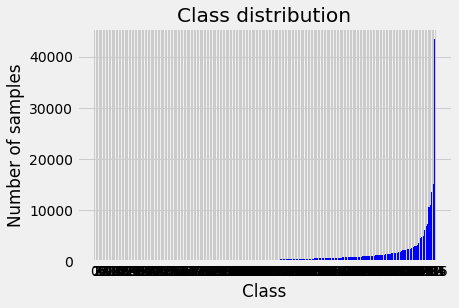

In [130]:
plt.style.use('fivethirtyeight')

# num_classes = get_num_classes(labels)
# count_map = Counter(labels)
# counts = [count_map[i] for i in range(num_classes)]
# idx = np.arange(num_classes)
index = np.arange(len(group_names))
plt.bar(group_names, group_data, width=0.8, color='b')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.xticks(index, index)
plt.show()


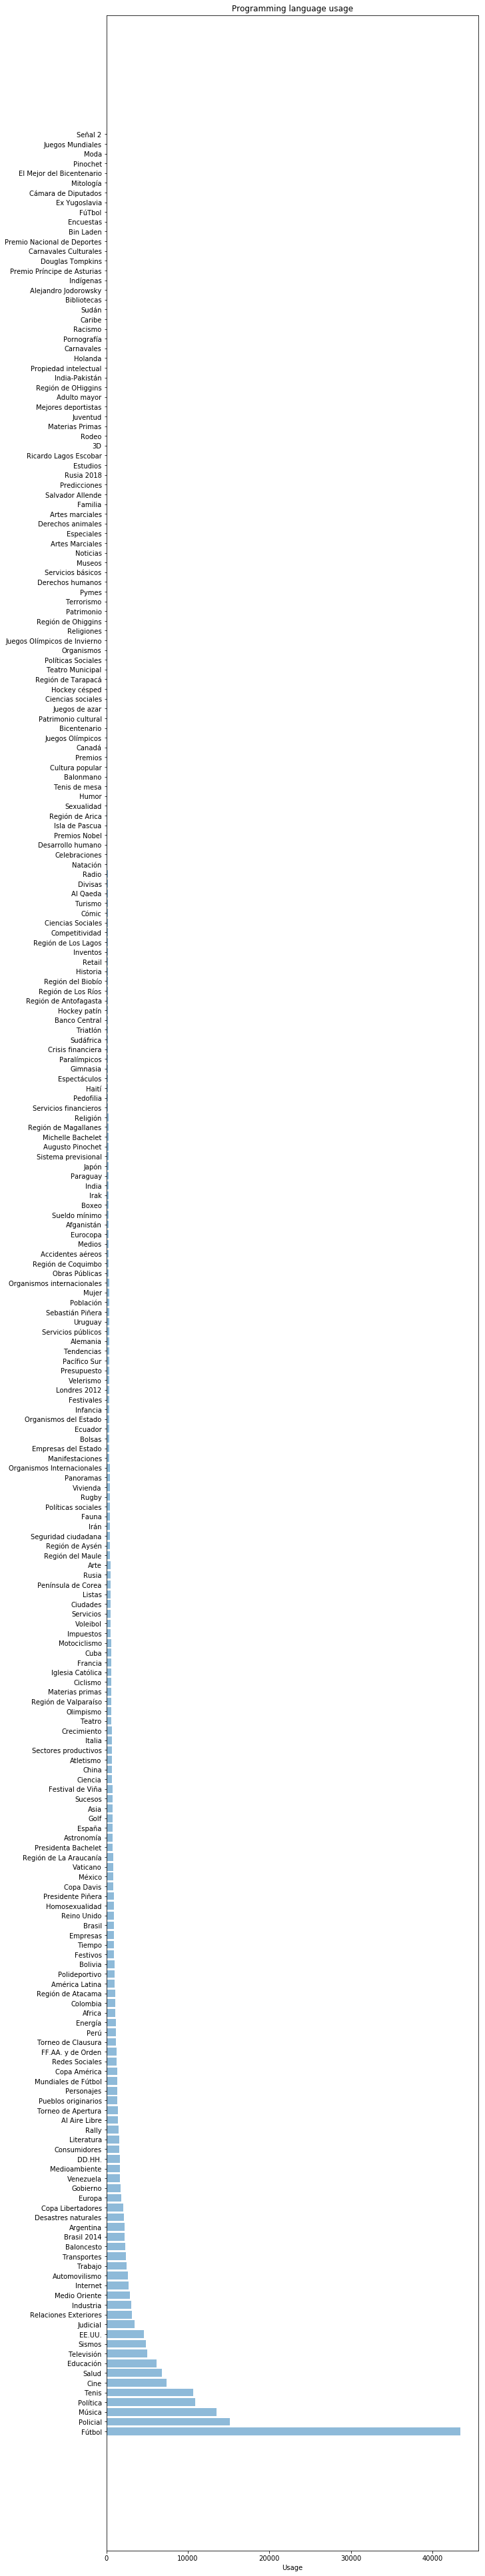

In [88]:

from matplotlib.pyplot import figure
objects = group_names
y_pos = np.arange(len(objects))
performance = group_data
figure(num=None, figsize=(10, 70))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)

plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Programming language usage')
 
plt.show()

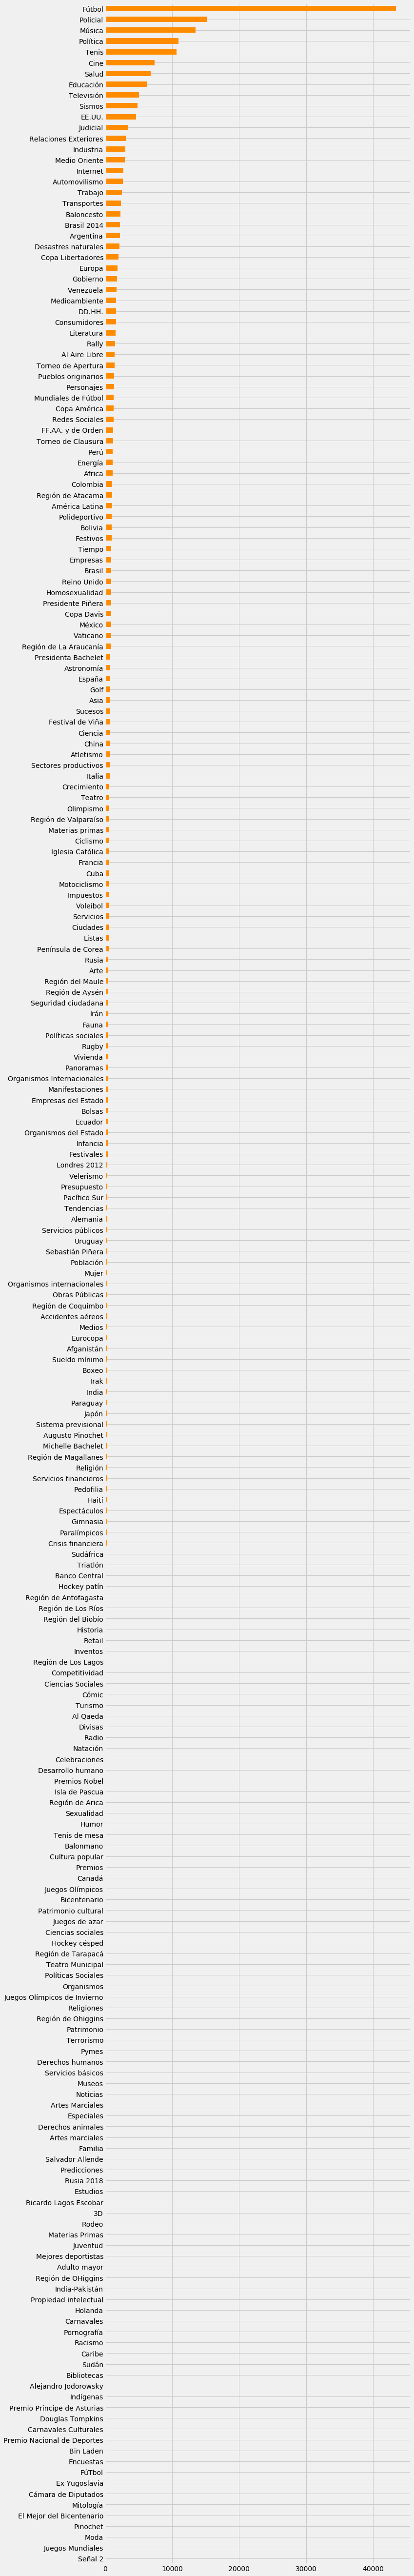

In [132]:
plt.style.use('fivethirtyeight')

tema_1=dfNoticias["Tema_1"].value_counts(ascending=True).plot.barh(color='DarkOrange',
                                                                   figsize=(10,90),
                                                                   grid=True)


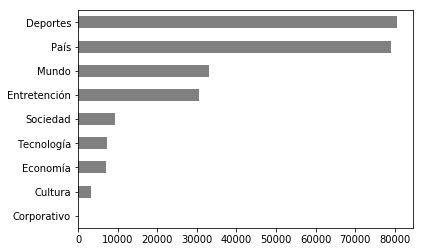

In [116]:
dfNoticias["Seccion_1"].value_counts(ascending=True).plot.barh(color='grey')

In [100]:
tema_1=dfNoticias["Tema_1"].value_counts(ascending=True)
tmp=tema_1
group_data =tmp.tolist()
group_names =tmp.index.tolist()

from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()
#output_file("bars.html")


p2 = figure(y_range=group_names[0:], plot_height=4000,plot_width=700, title="Fruit Counts",
           toolbar_location=None, tools="")

#p2.vbar(x=group_names[0:], top=group_data[0:], width=0.5)
p2.hbar(right=group_names[0:], y=group_data[0:], height=30)
p2.hbar(y=group_names[0:], right=group_data[0:], left=0, height=0.5)


p2.xgrid.grid_line_color = None
#p2.y_range.start = 0
p2.xaxis.major_label_orientation = 3.1416/4


show(p2)

Loading BokehJS ...

# pre procesing

Cleaning data, select clases

In [4]:
print('Selecting useful information...', end='')
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Seccion2"] = []
_map["Seccion3"] = []

count = 0
for index, row in dfNoticias.iterrows():
    if (row["Seccion_1"] != None and row["Cuerpo"] != None):
        _map["Cuerpo"].append(row["Cuerpo"]) 
        _map["Seccion"].append(row["Seccion_1"])
        if ( row["Seccion_2"] != None ):
            _map["Seccion2"].append(row["Seccion_2"])
        else:
            _map["Seccion2"].append(row["Seccion_1"])
        
        if ( row["Seccion_3"] != None ):
            _map["Seccion3"].append(row["Seccion_3"])
        else:
            _map["Seccion3"].append(row["Seccion_1"])
        
        
        if row["Seccion_1"] == row["Seccion_2"] and row["Seccion_2"] == row["Seccion_3"]:
            count += 1
        if row["Seccion_1"] == row["Seccion_2"] and row["Seccion_3"] == None:
            count += 1
        if row["Seccion_1"] == row["Seccion_3"] and row["Seccion_2"] == None:  
            count += 1 
        if row["Seccion_2"] == None and row["Seccion_3"] == None:
            count += 1
print('done.')



Selecting useful information...done.


In [5]:
df = pd.DataFrame(_map)
numberOfDuplicates = df.shape[0]
print('Number of data before dropping duplicates: {}'.format(df.shape[0]))
df = df.drop_duplicates(inplace= False)
df.reset_index(drop=True, inplace= True)
numberOfDuplicates -= df.shape[0]
print('Number of data after dropping duplicates : {}'.format(df.shape[0]))
print('\nNumber of duplicated data : {}'.format(numberOfDuplicates))

#df.head()

Number of data before dropping duplicates: 250339
Number of data after dropping duplicates : 238918

Number of duplicated data : 11421


In [6]:
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y_untransformed = df['Seccion'].reset_index(drop=True)

y2_untransformed = df['Seccion2'].reset_index(drop=True)
y3_untransformed = df['Seccion3'].reset_index(drop=True)


assert X_untransformed.shape[0] == y_untransformed.shape[0], 'X and y dimenssion must be the same.'
print('Number of data: {}'.format(X_untransformed.shape[0]))

Number of data: 238918


In [7]:
classes = df.groupby('Seccion')['Cuerpo'].nunique()

print(classes)
nClasses = classes.shape[0]

#print('\nNumber of classes: {}'.format(nClasses))

Seccion
Corporativo        82
Cultura          3128
Deportes        76458
Economía         6750
Entretención    29438
Mundo           31664
País            75180
Sociedad         9079
Tecnología       7130
Name: Cuerpo, dtype: int64


In [8]:
y2_untransformed

0             Deportes
1                Mundo
2                 País
3             Deportes
4                 País
5             Deportes
6                 País
7             Deportes
8                 País
9             Deportes
10                País
11         Corporativo
12            Deportes
13        Entretención
14               Mundo
15            Deportes
16                País
17                País
18                País
19            Deportes
20                País
21        Entretención
22        Entretención
23        Entretención
24                País
25            Deportes
26            Deportes
27            Deportes
28                País
29                País
              ...     
238888            País
238889      Tecnología
238890        Deportes
238891        Deportes
238892      Tecnología
238893        Deportes
238894    Entretención
238895           Mundo
238896      Tecnología
238897            País
238898            País
238899            País
238900     

In [11]:
set(dfNoticias.Tema_1)

{'3D',
 'Accidentes aéreos',
 'Adulto mayor',
 'Afganistán',
 'Africa',
 'Al Aire Libre',
 'Al Qaeda',
 'Alejandro Jodorowsky',
 'Alemania',
 'América Latina',
 'Argentina',
 'Arte',
 'Artes Marciales',
 'Artes marciales',
 'Asia',
 'Astronomía',
 'Atletismo',
 'Augusto Pinochet',
 'Automovilismo',
 'Baloncesto',
 'Balonmano',
 'Banco Central',
 'Bibliotecas',
 'Bicentenario',
 'Bin Laden',
 'Bolivia',
 'Bolsas',
 'Boxeo',
 'Brasil',
 'Brasil 2014',
 'Canadá',
 'Caribe',
 'Carnavales',
 'Carnavales Culturales',
 'Celebraciones',
 'China',
 'Ciclismo',
 'Ciencia',
 'Ciencias Sociales',
 'Ciencias sociales',
 'Cine',
 'Ciudades',
 'Colombia',
 'Competitividad',
 'Consumidores',
 'Copa América',
 'Copa Davis',
 'Copa Libertadores',
 'Crecimiento',
 'Crisis financiera',
 'Cuba',
 'Cultura popular',
 'Cámara de Diputados',
 'Cómic',
 'DD.HH.',
 'Derechos animales',
 'Derechos humanos',
 'Desarrollo humano',
 'Desastres naturales',
 'Divisas',
 'Douglas Tompkins',
 'EE.UU.',
 'Ecuador',
 'Ed

KeyboardInterrupt: 

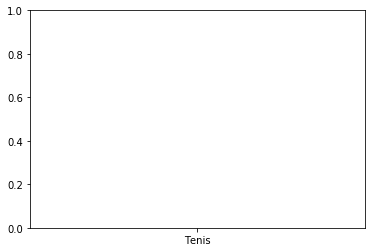

In [12]:
#dfNoticias.Tema_1.hist()

In [13]:
print(len(set(dfNoticias.Tema_1)))
print(len(set(dfNoticias.Tema_2)))
print(len(set(dfNoticias.Tema_3)))

238
238
220


In [56]:
set(dfNoticias.Tema_1)

{'3D',
 'Accidentes aéreos',
 'Adulto mayor',
 'Afganistán',
 'Africa',
 'Al Aire Libre',
 'Al Qaeda',
 'Alejandro Jodorowsky',
 'Alemania',
 'América Latina',
 'Argentina',
 'Arte',
 'Artes Marciales',
 'Artes marciales',
 'Asia',
 'Astronomía',
 'Atletismo',
 'Augusto Pinochet',
 'Automovilismo',
 'Baloncesto',
 'Balonmano',
 'Banco Central',
 'Bibliotecas',
 'Bicentenario',
 'Bin Laden',
 'Bolivia',
 'Bolsas',
 'Boxeo',
 'Brasil',
 'Brasil 2014',
 'Canadá',
 'Caribe',
 'Carnavales',
 'Carnavales Culturales',
 'Celebraciones',
 'China',
 'Ciclismo',
 'Ciencia',
 'Ciencias Sociales',
 'Ciencias sociales',
 'Cine',
 'Ciudades',
 'Colombia',
 'Competitividad',
 'Consumidores',
 'Copa América',
 'Copa Davis',
 'Copa Libertadores',
 'Crecimiento',
 'Crisis financiera',
 'Cuba',
 'Cultura popular',
 'Cámara de Diputados',
 'Cómic',
 'DD.HH.',
 'Derechos animales',
 'Derechos humanos',
 'Desarrollo humano',
 'Desastres naturales',
 'Divisas',
 'Douglas Tompkins',
 'EE.UU.',
 'Ecuador',
 'Ed

In [58]:
set(dfNoticias.Tema_3)

{'3D',
 'Accidentes aéreos',
 'Adulto mayor',
 'Afganistán',
 'Africa',
 'Al Aire Libre',
 'Al Qaeda',
 'Alejandro Jodorowsky',
 'Alemania',
 'América Latina',
 'Anecdotario',
 'Argentina',
 'Arte',
 'Artes Marciales',
 'Asia',
 'Astronomía',
 'Atletismo',
 'Augusto Pinochet',
 'Automovilismo',
 'Baloncesto',
 'Banco Central',
 'Bibliotecas',
 'Bicentenario',
 'Bolivia',
 'Bolsas',
 'Boxeo',
 'Brasil',
 'Brasil 2014',
 'Canadá',
 'Carnavales',
 'Carnavales Culturales',
 'Celebraciones',
 'China',
 'Ciclismo',
 'Ciencia',
 'Ciencias Sociales',
 'Ciencias sociales',
 'Cine',
 'Ciudades',
 'Colombia',
 'Competitividad',
 'Consumidores',
 'Copa América',
 'Copa Davis',
 'Copa Libertadores',
 'Crecimiento',
 'Crisis financiera',
 'Cuba',
 'Cultura popular',
 'Cómic',
 'DD.HH.',
 'Derechos animales',
 'Derechos humanos',
 'Desarrollo humano',
 'Desastres naturales',
 'Divisas',
 'EE.UU.',
 'Ecuador',
 'Educación',
 'Empresas',
 'Empresas del Estado',
 'Encuestas',
 'Energía',
 'España',
 'Es

In [14]:
print(len(set(dfNoticias.Subtema_1)))
print(len(set(dfNoticias.Subtema_2)))
print(len(set(dfNoticias.Subtema_3)))

1482
1271
903


In [36]:
tema_1=dfNoticias.Tema_1.value_counts()
print(len(tema_1))

237


In [35]:
print(tema_1.to_string())

Fútbol                          43438
Policial                        15166
Música                          13524
Política                        10918
Tenis                           10663
Cine                             7350
Salud                            6818
Educación                        6191
Televisión                       5035
Sismos                           4829
EE.UU.                           4584
Judicial                         3488
Relaciones Exteriores            3090
Industria                        3042
Medio Oriente                    2914
Internet                         2738
Automovilismo                    2665
Trabajo                          2480
Transportes                      2380
Baloncesto                       2309
Brasil 2014                      2226
Argentina                        2197
Desastres naturales              2153
Copa Libertadores                2031
Europa                           1839
Gobierno                         1750
Venezuela   

In [55]:
tema_1.to_dict()

{'3D': 29,
 'Accidentes aéreos': 294,
 'Adulto mayor': 22,
 'Afganistán': 285,
 'Africa': 1108,
 'Al Aire Libre': 1437,
 'Al Qaeda': 161,
 'Alejandro Jodorowsky': 11,
 'Alemania': 344,
 'América Latina': 1019,
 'Argentina': 2197,
 'Arte': 485,
 'Artes Marciales': 48,
 'Artes marciales': 44,
 'Asia': 746,
 'Astronomía': 776,
 'Atletismo': 698,
 'Augusto Pinochet': 254,
 'Automovilismo': 2665,
 'Baloncesto': 2309,
 'Balonmano': 106,
 'Banco Central': 203,
 'Bibliotecas': 11,
 'Bicentenario': 86,
 'Bin Laden': 3,
 'Bolivia': 1002,
 'Bolsas': 373,
 'Boxeo': 279,
 'Brasil': 929,
 'Brasil 2014': 2226,
 'Canadá': 101,
 'Caribe': 15,
 'Carnavales': 18,
 'Carnavales Culturales': 4,
 'Celebraciones': 127,
 'China': 715,
 'Ciclismo': 603,
 'Ciencia': 716,
 'Ciencias Sociales': 168,
 'Ciencias sociales': 73,
 'Cine': 7350,
 'Ciudades': 523,
 'Colombia': 1084,
 'Competitividad': 181,
 'Consumidores': 1603,
 'Copa América': 1293,
 'Copa Davis': 882,
 'Copa Libertadores': 2031,
 'Crecimiento': 643,
 

In [50]:

tmp=tema_1
group_data =tmp.tolist()
group_names =tmp.index.tolist()

from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()
#output_file("bars.html")


p2 = figure(x_range=group_names[0:], plot_height=700,plot_width=4000, title="Fruit Counts",
           toolbar_location=None, tools="")

p2.vbar(x=group_names[0:], top=group_data[0:], width=0.5)

p2.xgrid.grid_line_color = None
p2.y_range.start = 0
p2.xaxis.major_label_orientation = 3.1416/4


show(p2)

Loading BokehJS ...

Fútbol                          43438
Policial                        15166
Música                          13524
Política                        10918
Tenis                           10663
Cine                             7350
Salud                            6818
Educación                        6191
Televisión                       5035
Sismos                           4829
EE.UU.                           4584
Judicial                         3488
Relaciones Exteriores            3090
Industria                        3042
Medio Oriente                    2914
Internet                         2738
Automovilismo                    2665
Trabajo                          2480
Transportes                      2380
Baloncesto                       2309
Brasil 2014                      2226
Argentina                        2197
Desastres naturales              2153
Copa Libertadores                2031
Europa                           1839
Gobierno                         1750
Venezuela   

In [32]:
sub1=dfNoticias.Subtema_1.value_counts()
len(sub1)

1481

In [31]:
print(sub1.to_string())

Colo Colo                         3312
Catástrofe en Chile               3084
U. de Chile                       2819
Chilenos                          2607
Movimiento estudiantil            2574
Selección chilena                 2531
Torneos ATP                       2250
Presidenciales                    2249
Shows en Chile                    2117
Fórmula 1                         2073
U. Católica                       1908
Elecciones                        1753
Accidentes de tránsito            1751
Chile                             1617
NBA                               1549
Hollywood                         1509
Liga española                     1478
Sudáfrica 2010                    1307
Gremios                           1291
Chilenos en el exterior           1259
Liga inglesa                      1242
Música chilena                    1150
Liga de Campeones                 1149
Internacional                     1119
Incendios                         1109
Primera B                

In [59]:

tmp=sub1
group_data =tmp.tolist()
group_names =tmp.index.tolist()

from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()
#output_file("bars.html")


p2 = figure(x_range=group_names[0:], plot_height=700,plot_width=30000, title="Fruit Counts",
           toolbar_location=None, tools="")

p2.vbar(x=group_names[0:], top=group_data[0:], width=0.5)

p2.xgrid.grid_line_color = None
p2.y_range.start = 0
p2.xaxis.major_label_orientation = 3.1416/4


show(p2)

Loading BokehJS ...

In [60]:
tmp=sub1
group_data =tmp.tolist()
group_names =tmp.index.tolist()

from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()
#output_file("bars.html")


p3 = figure(x_range=group_names[0:], plot_height=700,plot_width=30000, title="Fruit Counts",
           toolbar_location=None, tools="")

p3.vbar(x=group_names[0:], top=group_data[0:], width=0.5)

p3.xgrid.grid_line_color = None
p3.y_range.start = 0
p3.xaxis.major_label_orientation = 3.1416/4


show(p3)

Loading BokehJS ...

In [61]:
sub1

Colo Colo                  3312
Catástrofe en Chile        3084
U. de Chile                2819
Chilenos                   2607
Movimiento estudiantil     2574
Selección chilena          2531
Torneos ATP                2250
Presidenciales             2249
Shows en Chile             2117
Fórmula 1                  2073
U. Católica                1908
Elecciones                 1753
Accidentes de tránsito     1751
Chile                      1617
NBA                        1549
Hollywood                  1509
Liga española              1478
Sudáfrica 2010             1307
Gremios                    1291
Chilenos en el exterior    1259
Liga inglesa               1242
Música chilena             1150
Liga de Campeones          1149
Internacional              1119
Incendios                  1109
Primera B                  1081
Copa Chile                 1014
Liga italiana              1001
Copa Sudamericana          1001
Drogas                      996
                           ... 
Caso Aer